# Raw Data Extraction

Creating dataset with images and labels from the pure set of videos and the json file.

In [2]:
from src.data import process_all_splits

In [3]:
VIDEO_ROOT = "C:\\Users\\sandr\\Downloads\\trailer\\trailer"
JSON_PATH = "C:\\Users\\sandr\\Downloads\\v1_split_trailer.json"
IMAGE_QUALITY = 15
OUTPUT_DIR = "./data"

In [4]:
extrac_data = False
if extrac_data:
    process_all_splits(VIDEO_ROOT, JSON_PATH, IMAGE_QUALITY, OUTPUT_DIR) # took 1h and 8 minutes with ≈8frames/s

# Dataset Creation

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from src.data import LensTypeDataset
from collections import Counter
from tqdm import tqdm
import os
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

noise_stds = [0.05, 0.1, 0.2, 0.4, 0.5]
noise_percentage = 0.3

train_dataset = LensTypeDataset(root_dir="./data", split="train", transform=transform_train,
                                noisy_percentage=noise_percentage, noise_stds=noise_stds, seed=SEED)
val_dataset = LensTypeDataset(root_dir="./data", split="val", transform=transform_val, noisy_percentage=0.0)
test_dataset = LensTypeDataset(root_dir="./data", split="test", transform=transform_val, noisy_percentage=0.0)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
print(f"Images in train: {len(train_dataset)}")
print(f"Images in val: {len(val_dataset)}")
print(f"Images in test: {len(test_dataset)}")
print(f"Total number of images: {len(test_dataset) + len(val_dataset) + len(train_dataset)}")

Images in train: 20856
Images in val: 4610
Images in test: 8187
Total number of images: 33653


In [5]:
print(f"Train label count: {Counter(train_dataset.labels)}")
print(f"Val label count: {Counter(val_dataset.labels)}")
print(f"Test label count: {Counter(test_dataset.labels)}")

Train label count: Counter({2: 4650, 1: 4529, 3: 4275, 0: 3946, 4: 3456})
Val label count: Counter({1: 1049, 2: 1006, 0: 922, 3: 886, 4: 747})
Test label count: Counter({1: 1792, 2: 1753, 3: 1642, 0: 1641, 4: 1359})


In [6]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])


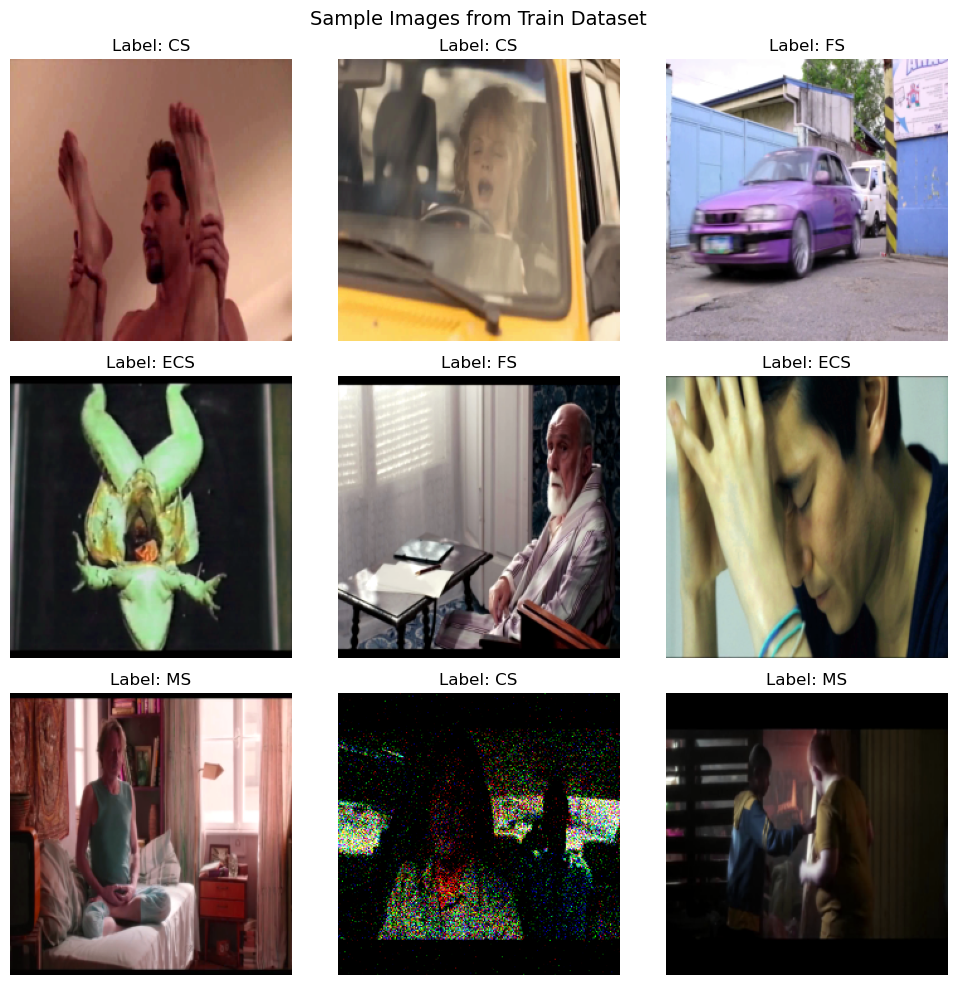

In [7]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Sample Images from Train Dataset", fontsize=14)

label_mapping = {0: "ECS", 1: "CS", 2: "MS", 3: "FS", 4: "LS"}

for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()  # (C, H, W) to (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    ax.set_title(f"Label: {label_mapping[labels[i].item()]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Fine-tuning

Now let's train the classifier, which we will use later for the guidance in the image generation. We'll use EfficientNetB3.

In [8]:
model = models.efficientnet_b3(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/users/eleves-a/2024/elio.samaha/.conda/envs/env-lab6/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-a/2024/elio.samaha/.conda/envs/env-lab6/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
in_feats = model.classifier[1].in_features # 1536
model.classifier = nn.Sequential(
    nn.Linear(in_feats, 512),
    nn.SiLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, 5)
)

for param in model.classifier.parameters():
    param.requires_grad = True

In [10]:
model = model.to(device)
# model

In [11]:
epochs = 5

def train_one_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    acc = correct / len(train_loader.dataset)
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {acc:.4f}")

    return avg_loss, acc

def validate(model, val_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    acc = correct / len(val_loader.dataset)
    print(f"Val Loss: {avg_loss:.4f}, Val Accuracy: {acc:.4f}")

    return avg_loss, acc

In [12]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

best_val_acc = 0
os.makedirs("checkpoints", exist_ok=True)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "checkpoints/lens_classifier_best_model.pth")
        print("Model Saved!")

print("Training Complete!")

Training Epoch 1/5: 100%|██████████| 326/326 [04:43<00:00,  1.15it/s]


Train Loss: 1.1359, Train Accuracy: 0.6085


Validating: 100%|██████████| 73/73 [00:46<00:00,  1.57it/s]


Val Loss: 0.9390, Val Accuracy: 0.7315
Model Saved!


Training Epoch 2/5: 100%|██████████| 326/326 [04:44<00:00,  1.15it/s]


Train Loss: 1.0503, Train Accuracy: 0.6437


Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Val Loss: 0.9308, Val Accuracy: 0.7338
Model Saved!


Training Epoch 3/5: 100%|██████████| 326/326 [04:42<00:00,  1.16it/s]


Train Loss: 1.0362, Train Accuracy: 0.6517


Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Val Loss: 0.9156, Val Accuracy: 0.7416
Model Saved!


Training Epoch 4/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]


Train Loss: 1.0211, Train Accuracy: 0.6638


Validating: 100%|██████████| 73/73 [00:45<00:00,  1.61it/s]


Val Loss: 0.9085, Val Accuracy: 0.7505
Model Saved!


Training Epoch 5/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]


Train Loss: 1.0106, Train Accuracy: 0.6687


Validating: 100%|██████████| 73/73 [00:45<00:00,  1.61it/s]

Val Loss: 0.9092, Val Accuracy: 0.7460
Training Complete!


In [ ]:
# RESULTS

# 1
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# ---
# Training Epoch 1/5: 100%|██████████| 326/326 [05:07<00:00,  1.06it/s]
# Train Loss: 0.9905, Train Accuracy: 0.6051
# Validating: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]
# Val Loss: 0.7138, Val Accuracy: 0.7278
# Model Saved!
# Training Epoch 2/5: 100%|██████████| 326/326 [04:42<00:00,  1.15it/s]
# Train Loss: 0.8670, Train Accuracy: 0.6414
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]
# Val Loss: 0.7049, Val Accuracy: 0.7291
# Model Saved!
# Training Epoch 3/5: 100%|██████████| 326/326 [04:43<00:00,  1.15it/s]
# Train Loss: 0.8513, Train Accuracy: 0.6502
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.60it/s]
# Val Loss: 0.6835, Val Accuracy: 0.7425
# Model Saved!
# Training Epoch 4/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]
# Train Loss: 0.8341, Train Accuracy: 0.6590
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.60it/s]
# Val Loss: 0.6733, Val Accuracy: 0.7406
# Training Epoch 5/5: 100%|██████████| 326/326 [04:42<00:00,  1.15it/s]
# Train Loss: 0.8184, Train Accuracy: 0.6612
# Validating: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s]
# Val Loss: 0.6824, Val Accuracy: 0.7358
# Training Complete!

# 2
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # add label smoothing because in the end the shot type is not a so "discrete" model
# optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# ---
# Training Epoch 1/5: 100%|██████████| 326/326 [04:43<00:00,  1.15it/s]
# Train Loss: 1.1359, Train Accuracy: 0.6085
# Validating: 100%|██████████| 73/73 [00:46<00:00,  1.57it/s]
# Val Loss: 0.9390, Val Accuracy: 0.7315
# Model Saved!
# Training Epoch 2/5: 100%|██████████| 326/326 [04:44<00:00,  1.15it/s]
# Train Loss: 1.0503, Train Accuracy: 0.6437
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]
# Val Loss: 0.9308, Val Accuracy: 0.7338
# Model Saved!
# Training Epoch 3/5: 100%|██████████| 326/326 [04:42<00:00,  1.16it/s]
# Train Loss: 1.0362, Train Accuracy: 0.6517
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s]
# Val Loss: 0.9156, Val Accuracy: 0.7416
# Model Saved!
# Training Epoch 4/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]
# Train Loss: 1.0211, Train Accuracy: 0.6638
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.61it/s]
# Val Loss: 0.9085, Val Accuracy: 0.7505
# Model Saved!
# Training Epoch 5/5: 100%|██████████| 326/326 [04:41<00:00,  1.16it/s]
# Train Loss: 1.0106, Train Accuracy: 0.6687
# Validating: 100%|██████████| 73/73 [00:45<00:00,  1.61it/s]
# Val Loss: 0.9092, Val Accuracy: 0.7460
# Training Complete!

## Optuna Finetuning

In [11]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

def objective(trial):
    # Suggest hyperparameters:
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    
    # Build the model: Fine-tune EfficientNetB3 (only classifier parameters are trainable)
    model = models.efficientnet_b3(pretrained=True)
    # Freeze all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False
    in_feats = model.classifier[1].in_features  # e.g., 1536
    model.classifier = nn.Sequential(
        nn.Linear(in_feats, 512),
        nn.SiLU(inplace=True),
        nn.Dropout(dropout_rate),
        nn.Linear(512, 5)
    )
    for param in model.classifier.parameters():
        param.requires_grad = True
    model = model.to(device)
    
    # Define loss, optimizer, and scheduler.
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Using CosineAnnealingLR; adjust T_max as needed (here we set T_max equal to number of epochs)
    epochs_optuna = 3  # training for 3 epochs for speed during hyperparameter search
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs_optuna)
    
    # Train for a few epochs
    for epoch in range(epochs_optuna):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = validate(model, val_loader, criterion)
        scheduler.step()
    
    # Here we return the validation loss as the objective.
    # (Optuna minimizes by default, and a lower validation loss indicates better performance.)
    return val_loss

# Create an Optuna study to minimize the objective (validation loss)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Print the best hyperparameters found.
print("Best trial:")
print(study.best_trial)

/users/eleves-a/2024/elio.samaha/.conda/envs/env-lab6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-22 10:46:27,269] A new study created in memory with name: no-name-5d271024-e267-4d4e-898a-b12f00a16d74
/tmp/ipykernel_3243224/3410726668.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/tmp/ipykernel_3243224/3410726668.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay",

Train Loss: 1.4833, Train Accuracy: 0.4318


Validating: 100%|██████████| 73/73 [01:26<00:00,  1.18s/it]


Val Loss: 1.3336, Val Accuracy: 0.6278


Training Epoch 2/5: 100%|██████████| 326/326 [07:17<00:00,  1.34s/it]


Train Loss: 1.2935, Train Accuracy: 0.5853


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 1.1755, Val Accuracy: 0.6790


Training Epoch 3/5: 100%|██████████| 326/326 [07:17<00:00,  1.34s/it]


Train Loss: 1.2139, Train Accuracy: 0.6055


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]
[I 2025-02-22 11:12:53,149] Trial 0 finished with value: 1.1338315377496693 and parameters: {'lr': 2.0303081113512664e-05, 'weight_decay': 1.3034735646945605e-05, 'dropout_rate': 0.206577235348853}. Best is trial 0 with value: 1.1338315377496693.


Val Loss: 1.1338, Val Accuracy: 0.6879


Training Epoch 1/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.1227, Train Accuracy: 0.6005


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9464, Val Accuracy: 0.7223


Training Epoch 2/5: 100%|██████████| 326/326 [07:17<00:00,  1.34s/it]


Train Loss: 1.0446, Train Accuracy: 0.6475


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Val Loss: 0.9251, Val Accuracy: 0.7408


Training Epoch 3/5: 100%|██████████| 326/326 [07:18<00:00,  1.35s/it]


Train Loss: 1.0280, Train Accuracy: 0.6607


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 11:38:46,566] Trial 1 finished with value: 0.9164307435897932 and parameters: {'lr': 0.0005633360284407433, 'weight_decay': 0.0005675652075146139, 'dropout_rate': 0.37512466733001937}. Best is trial 1 with value: 0.9164307435897932.


Val Loss: 0.9164, Val Accuracy: 0.7434


Training Epoch 1/5: 100%|██████████| 326/326 [07:19<00:00,  1.35s/it]


Train Loss: 1.1035, Train Accuracy: 0.6139


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Val Loss: 0.9390, Val Accuracy: 0.7338


Training Epoch 2/5: 100%|██████████| 326/326 [07:18<00:00,  1.35s/it]


Train Loss: 1.0379, Train Accuracy: 0.6521


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9229, Val Accuracy: 0.7393


Training Epoch 3/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0146, Train Accuracy: 0.6647


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 12:04:42,122] Trial 2 finished with value: 0.913684218713682 and parameters: {'lr': 0.0007627032943199047, 'weight_decay': 9.932448621075609e-05, 'dropout_rate': 0.14107147533367428}. Best is trial 2 with value: 0.913684218713682.


Val Loss: 0.9137, Val Accuracy: 0.7492


Training Epoch 1/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.1168, Train Accuracy: 0.6063


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9362, Val Accuracy: 0.7373


Training Epoch 2/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0438, Train Accuracy: 0.6515


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Val Loss: 0.9287, Val Accuracy: 0.7393


Training Epoch 3/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0249, Train Accuracy: 0.6588


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 12:30:28,823] Trial 3 finished with value: 0.9203416999072245 and parameters: {'lr': 0.0004951947478448556, 'weight_decay': 0.0002852958338424853, 'dropout_rate': 0.14859423718248413}. Best is trial 2 with value: 0.913684218713682.


Val Loss: 0.9203, Val Accuracy: 0.7377


Training Epoch 1/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.1957, Train Accuracy: 0.5759


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9719, Val Accuracy: 0.7154


Training Epoch 2/5: 100%|██████████| 326/326 [07:18<00:00,  1.35s/it]


Train Loss: 1.0627, Train Accuracy: 0.6411


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9466, Val Accuracy: 0.7384


Training Epoch 3/5: 100%|██████████| 326/326 [07:17<00:00,  1.34s/it]


Train Loss: 1.0473, Train Accuracy: 0.6505


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]
[I 2025-02-22 12:56:22,282] Trial 4 finished with value: 0.9408903620014452 and parameters: {'lr': 0.00014225085933109016, 'weight_decay': 0.0001691374621447712, 'dropout_rate': 0.29478836304988976}. Best is trial 2 with value: 0.913684218713682.


Val Loss: 0.9409, Val Accuracy: 0.7375


Training Epoch 1/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.4497, Train Accuracy: 0.4561


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Val Loss: 1.2666, Val Accuracy: 0.6725


Training Epoch 2/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.2344, Train Accuracy: 0.5923


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 1.1089, Val Accuracy: 0.6978


Training Epoch 3/5: 100%|██████████| 326/326 [07:15<00:00,  1.33s/it]


Train Loss: 1.1658, Train Accuracy: 0.6128


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 13:22:09,601] Trial 5 finished with value: 1.0756856203079224 and parameters: {'lr': 3.0029463939081532e-05, 'weight_decay': 2.397734738398885e-05, 'dropout_rate': 0.4677190238086455}. Best is trial 2 with value: 0.913684218713682.


Val Loss: 1.0757, Val Accuracy: 0.7024


Training Epoch 1/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 1.5277, Train Accuracy: 0.3751


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 1.4310, Val Accuracy: 0.5711


Training Epoch 2/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 1.4031, Train Accuracy: 0.5245


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 1.3145, Val Accuracy: 0.6547


Training Epoch 3/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 1.3359, Train Accuracy: 0.5705


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 13:47:51,906] Trial 6 finished with value: 1.2741127618371624 and parameters: {'lr': 1.4497479080846255e-05, 'weight_decay': 0.0002674840866864861, 'dropout_rate': 0.48053369161944637}. Best is trial 2 with value: 0.913684218713682.


Val Loss: 1.2741, Val Accuracy: 0.6601


Training Epoch 1/5: 100%|██████████| 326/326 [07:18<00:00,  1.35s/it]


Train Loss: 1.2385, Train Accuracy: 0.5598


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9851, Val Accuracy: 0.7184


Training Epoch 2/5: 100%|██████████| 326/326 [07:17<00:00,  1.34s/it]


Train Loss: 1.0669, Train Accuracy: 0.6428


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9592, Val Accuracy: 0.7271


Training Epoch 3/5: 100%|██████████| 326/326 [07:18<00:00,  1.34s/it]


Train Loss: 1.0535, Train Accuracy: 0.6493


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]
[I 2025-02-22 14:13:47,400] Trial 7 finished with value: 0.9529676135272196 and parameters: {'lr': 9.488979892754094e-05, 'weight_decay': 0.00012979432766215004, 'dropout_rate': 0.12984739710433602}. Best is trial 2 with value: 0.913684218713682.


Val Loss: 0.9530, Val Accuracy: 0.7334


Training Epoch 1/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.1115, Train Accuracy: 0.6060


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9346, Val Accuracy: 0.7336


Training Epoch 2/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0358, Train Accuracy: 0.6554


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Val Loss: 0.9363, Val Accuracy: 0.7334


Training Epoch 3/5: 100%|██████████| 326/326 [07:17<00:00,  1.34s/it]


Train Loss: 1.0158, Train Accuracy: 0.6692


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]
[I 2025-02-22 14:39:36,342] Trial 8 finished with value: 0.9107510937403326 and parameters: {'lr': 0.0006609704135552845, 'weight_decay': 3.227705285088108e-05, 'dropout_rate': 0.13979156262153372}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9108, Val Accuracy: 0.7475


Training Epoch 1/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.1242, Train Accuracy: 0.6028


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9527, Val Accuracy: 0.7252


Training Epoch 2/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0442, Train Accuracy: 0.6480


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9338, Val Accuracy: 0.7321


Training Epoch 3/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0276, Train Accuracy: 0.6567


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]
[I 2025-02-22 15:05:25,920] Trial 9 finished with value: 0.9242318917627204 and parameters: {'lr': 0.00044554595331247024, 'weight_decay': 0.0009417543028463229, 'dropout_rate': 0.23663575774587906}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9242, Val Accuracy: 0.7403


Training Epoch 1/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.1638, Train Accuracy: 0.5902


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9576, Val Accuracy: 0.7267


Training Epoch 2/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0558, Train Accuracy: 0.6472


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Val Loss: 0.9474, Val Accuracy: 0.7336


Training Epoch 3/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0407, Train Accuracy: 0.6528


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 15:31:12,432] Trial 10 finished with value: 0.9365792748046248 and parameters: {'lr': 0.00020628921634637654, 'weight_decay': 3.9743207748346394e-05, 'dropout_rate': 0.34111719264608714}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9366, Val Accuracy: 0.7436


Training Epoch 1/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.1093, Train Accuracy: 0.6089


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9457, Val Accuracy: 0.7245


Training Epoch 2/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0422, Train Accuracy: 0.6450


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9246, Val Accuracy: 0.7345


Training Epoch 3/5: 100%|██████████| 326/326 [07:15<00:00,  1.33s/it]


Train Loss: 1.0085, Train Accuracy: 0.6664


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 15:56:59,337] Trial 11 finished with value: 0.916142077478644 and parameters: {'lr': 0.0009523299279401581, 'weight_decay': 5.816358202975305e-05, 'dropout_rate': 0.11722348941516245}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9161, Val Accuracy: 0.7414


Training Epoch 1/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.1084, Train Accuracy: 0.6081


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Val Loss: 0.9340, Val Accuracy: 0.7390


Training Epoch 2/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0376, Train Accuracy: 0.6495


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9219, Val Accuracy: 0.7380


Training Epoch 3/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0075, Train Accuracy: 0.6675


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 16:22:47,558] Trial 12 finished with value: 0.9144649276994679 and parameters: {'lr': 0.0009730679986130517, 'weight_decay': 5.679831324540279e-05, 'dropout_rate': 0.20580170555829147}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9145, Val Accuracy: 0.7445


Training Epoch 1/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 1.1417, Train Accuracy: 0.6007


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9535, Val Accuracy: 0.7347


Training Epoch 2/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0505, Train Accuracy: 0.6479


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9292, Val Accuracy: 0.7479


Training Epoch 3/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0288, Train Accuracy: 0.6567


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.08s/it]
[I 2025-02-22 16:48:31,320] Trial 13 finished with value: 0.9317695759747127 and parameters: {'lr': 0.0002480411079725465, 'weight_decay': 1.0627093270595779e-05, 'dropout_rate': 0.10223672911504929}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9318, Val Accuracy: 0.7403


Training Epoch 1/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 1.2704, Train Accuracy: 0.5448


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Val Loss: 1.0089, Val Accuracy: 0.7150


Training Epoch 2/5: 100%|██████████| 326/326 [07:15<00:00,  1.33s/it]


Train Loss: 1.0880, Train Accuracy: 0.6307


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9648, Val Accuracy: 0.7306


Training Epoch 3/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0649, Train Accuracy: 0.6445


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]
[I 2025-02-22 17:14:17,370] Trial 14 finished with value: 0.9594489327848774 and parameters: {'lr': 7.540881604964822e-05, 'weight_decay': 2.6478726488571324e-05, 'dropout_rate': 0.19207971897260478}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9594, Val Accuracy: 0.7286


Training Epoch 1/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.1426, Train Accuracy: 0.5998


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9502, Val Accuracy: 0.7330


Training Epoch 2/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 1.0440, Train Accuracy: 0.6542


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9299, Val Accuracy: 0.7432


Training Epoch 3/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 1.0324, Train Accuracy: 0.6576


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 17:40:01,939] Trial 15 finished with value: 0.9309258918239646 and parameters: {'lr': 0.0002597475551460488, 'weight_decay': 7.976432864884295e-05, 'dropout_rate': 0.25766380378968246}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9309, Val Accuracy: 0.7460


Training Epoch 1/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.2989, Train Accuracy: 0.5390


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Val Loss: 1.0318, Val Accuracy: 0.7065


Training Epoch 2/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0920, Train Accuracy: 0.6283


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Val Loss: 0.9746, Val Accuracy: 0.7228


Training Epoch 3/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0682, Train Accuracy: 0.6418


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 18:05:50,782] Trial 16 finished with value: 0.9694644269877917 and parameters: {'lr': 6.332431441545682e-05, 'weight_decay': 2.5561381443484795e-05, 'dropout_rate': 0.1737977143328916}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9695, Val Accuracy: 0.7278


Training Epoch 1/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.1387, Train Accuracy: 0.5972


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Val Loss: 0.9422, Val Accuracy: 0.7325


Training Epoch 2/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0507, Train Accuracy: 0.6489


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9301, Val Accuracy: 0.7447


Training Epoch 3/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0308, Train Accuracy: 0.6591


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 18:31:39,241] Trial 17 finished with value: 0.925086550516625 and parameters: {'lr': 0.00035515736094546415, 'weight_decay': 0.0001004668783228492, 'dropout_rate': 0.41369634961847335}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9251, Val Accuracy: 0.7430


Training Epoch 1/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.1128, Train Accuracy: 0.6054


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9436, Val Accuracy: 0.7286


Training Epoch 2/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0454, Train Accuracy: 0.6477


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 0.9253, Val Accuracy: 0.7380


Training Epoch 3/5: 100%|██████████| 326/326 [07:17<00:00,  1.34s/it]


Train Loss: 1.0183, Train Accuracy: 0.6652


Validating: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]
[I 2025-02-22 18:57:29,531] Trial 18 finished with value: 0.9163989383880407 and parameters: {'lr': 0.0007073127081886931, 'weight_decay': 4.054209520764404e-05, 'dropout_rate': 0.2843641804064194}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9164, Val Accuracy: 0.7466


Training Epoch 1/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.3442, Train Accuracy: 0.5129


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Val Loss: 1.0807, Val Accuracy: 0.6996


Training Epoch 2/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.1124, Train Accuracy: 0.6198


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Val Loss: 0.9963, Val Accuracy: 0.7182


Training Epoch 3/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 1.0842, Train Accuracy: 0.6336


Validating: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
[I 2025-02-22 19:23:18,698] Trial 19 finished with value: 0.9828788033903462 and parameters: {'lr': 5.0268303869423825e-05, 'weight_decay': 0.00020593547335816996, 'dropout_rate': 0.16852023708293265}. Best is trial 8 with value: 0.9107510937403326.


Val Loss: 0.9829, Val Accuracy: 0.7215
Best trial:
FrozenTrial(number=8, state=1, values=[0.9107510937403326], datetime_start=datetime.datetime(2025, 2, 22, 14, 13, 47, 400309), datetime_complete=datetime.datetime(2025, 2, 22, 14, 39, 36, 342497), params={'lr': 0.0006609704135552845, 'weight_decay': 3.227705285088108e-05, 'dropout_rate': 0.13979156262153372}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.1, step=None)}, trial_id=8, value=None)


# Full Training with best Hyperparameters

In [12]:
# Save best hyperparameters from the Optuna study (assume study.best_trial.params exists)
best_hyperparams = study.best_trial.params

In [13]:
best_hyperparams

{'lr': 0.0006609704135552845,
 'weight_decay': 3.227705285088108e-05,
 'dropout_rate': 0.13979156262153372}

In [14]:
import json

with open("best_hyperparams.json", "w") as f:
    json.dump(best_hyperparams, f)
print("Best hyperparameters saved.")

# Later, load the hyperparameters
with open("best_hyperparams.json", "r") as f:
    best_hyperparams = json.load(f)
print("Best hyperparameters loaded:", best_hyperparams)


Best hyperparameters saved.
Best hyperparameters loaded: {'lr': 0.0006609704135552845, 'weight_decay': 3.227705285088108e-05, 'dropout_rate': 0.13979156262153372}


In [15]:
best_hyperparams

{'lr': 0.0006609704135552845,
 'weight_decay': 3.227705285088108e-05,
 'dropout_rate': 0.13979156262153372}

In [ ]:
import copy
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm  # Ensure tqdm is imported

# Build the model using EfficientNetB3 as in your fine-tuning code
model = models.efficientnet_b3(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
in_feats = model.classifier[1].in_features  # e.g., 1536

# Use the best hyperparameters for dropout, learning rate, and weight decay.
# If a hyperparameter is missing in the JSON file, we set a default.
dropout_rate = best_hyperparams.get("dropout_rate", 0.3)
lr = best_hyperparams.get("lr", 3e-4)
weight_decay = best_hyperparams.get("weight_decay", 1e-4)

model.classifier = nn.Sequential(
    nn.Linear(in_feats, 512),
    nn.SiLU(inplace=True),
    nn.Dropout(dropout_rate),
    nn.Linear(512, 5)
)
for param in model.classifier.parameters():
    param.requires_grad = True
model = model.to(device)

# Define the loss function, optimizer, and learning rate scheduler.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Soft early stopping parameters
patience = 10
min_improvement = 0.001  # minimal decrease in validation loss to be considered an improvement

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

num_epochs = 100
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Check if validation loss has improved by at least the minimal threshold.
    if best_val_loss - val_loss > min_improvement:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print("Validation loss improved. Model saved!")
    else:
        epochs_no_improve += 1
        print(f"No significant improvement for {epochs_no_improve} epochs.")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

/users/eleves-a/2024/elio.samaha/.conda/envs/env-lab6/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-a/2024/elio.samaha/.conda/envs/env-lab6/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100


Training Epoch 1/5: 100%|██████████| 326/326 [07:11<00:00,  1.32s/it]


Train Loss: 1.1105, Train Accuracy: 0.6123


Training Epochs:   1%|          | 1/100 [08:31<14:03:18, 511.09s/it]

Val Loss: 0.9417, Val Accuracy: 0.7304
Validation loss improved. Model saved!
Epoch 2/100


Training Epoch 2/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 1.0434, Train Accuracy: 0.6488


Training Epochs:   2%|▏         | 2/100 [17:04<13:57:19, 512.65s/it]

Val Loss: 0.9239, Val Accuracy: 0.7371
Validation loss improved. Model saved!
Epoch 3/100


Training Epoch 3/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0276, Train Accuracy: 0.6571


Training Epochs:   3%|▎         | 3/100 [25:40<13:51:04, 514.07s/it]

Val Loss: 0.9286, Val Accuracy: 0.7367
No significant improvement for 1 epochs.
Epoch 4/100


Training Epoch 4/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0156, Train Accuracy: 0.6596


Training Epochs:   4%|▍         | 4/100 [34:16<13:43:24, 514.63s/it]

Val Loss: 0.9154, Val Accuracy: 0.7473
Validation loss improved. Model saved!
Epoch 5/100


Training Epoch 5/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 1.0108, Train Accuracy: 0.6633


Training Epochs:   5%|▌         | 5/100 [42:50<13:34:58, 514.72s/it]

Val Loss: 0.9105, Val Accuracy: 0.7462
Validation loss improved. Model saved!
Epoch 6/100


Training Epoch 6/5: 100%|██████████| 326/326 [07:15<00:00,  1.33s/it]


Train Loss: 0.9941, Train Accuracy: 0.6766


Training Epochs:   6%|▌         | 6/100 [51:25<13:26:30, 514.79s/it]

Val Loss: 0.9107, Val Accuracy: 0.7430
No significant improvement for 1 epochs.
Epoch 7/100


Training Epoch 7/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 0.9941, Train Accuracy: 0.6733


Training Epochs:   7%|▋         | 7/100 [59:59<13:17:15, 514.36s/it]

Val Loss: 0.9114, Val Accuracy: 0.7445
No significant improvement for 2 epochs.
Epoch 8/100


Training Epoch 8/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 0.9832, Train Accuracy: 0.6810


Training Epochs:   8%|▊         | 8/100 [1:08:34<13:08:52, 514.49s/it]

Val Loss: 0.9031, Val Accuracy: 0.7527
Validation loss improved. Model saved!
Epoch 9/100


Training Epoch 9/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 0.9752, Train Accuracy: 0.6871


Training Epochs:   9%|▉         | 9/100 [1:17:08<13:00:04, 514.34s/it]

Val Loss: 0.9115, Val Accuracy: 0.7416
No significant improvement for 1 epochs.
Epoch 10/100


Training Epoch 10/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 0.9726, Train Accuracy: 0.6872


Training Epochs:  10%|█         | 10/100 [1:25:42<12:51:40, 514.45s/it]

Val Loss: 0.8954, Val Accuracy: 0.7495
Validation loss improved. Model saved!
Epoch 11/100


Training Epoch 11/5: 100%|██████████| 326/326 [07:13<00:00,  1.33s/it]


Train Loss: 0.9642, Train Accuracy: 0.6920


Training Epochs:  11%|█         | 11/100 [1:34:15<12:42:22, 513.96s/it]

Val Loss: 0.8964, Val Accuracy: 0.7575
No significant improvement for 1 epochs.
Epoch 12/100


Training Epoch 12/5: 100%|██████████| 326/326 [07:13<00:00,  1.33s/it]


Train Loss: 0.9572, Train Accuracy: 0.6954


Training Epochs:  12%|█▏        | 12/100 [1:42:48<12:33:27, 513.72s/it]

Val Loss: 0.9040, Val Accuracy: 0.7579
No significant improvement for 2 epochs.
Epoch 13/100


Training Epoch 13/5: 100%|██████████| 326/326 [07:16<00:00,  1.34s/it]


Train Loss: 0.9404, Train Accuracy: 0.7085


Training Epochs:  13%|█▎        | 13/100 [1:51:24<12:25:38, 514.24s/it]

Val Loss: 0.9046, Val Accuracy: 0.7484
No significant improvement for 3 epochs.
Epoch 14/100


Training Epoch 14/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 0.9376, Train Accuracy: 0.7097


Training Epochs:  14%|█▍        | 14/100 [1:59:58<12:17:01, 514.20s/it]

Val Loss: 0.9007, Val Accuracy: 0.7499
No significant improvement for 4 epochs.
Epoch 15/100


Training Epoch 15/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 0.9297, Train Accuracy: 0.7128


Training Epochs:  15%|█▌        | 15/100 [2:08:32<12:08:17, 514.09s/it]

Val Loss: 0.9066, Val Accuracy: 0.7508
No significant improvement for 5 epochs.
Epoch 16/100


Training Epoch 16/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 0.9237, Train Accuracy: 0.7143


Training Epochs:  16%|█▌        | 16/100 [2:17:06<11:59:41, 514.06s/it]

Val Loss: 0.9140, Val Accuracy: 0.7516
No significant improvement for 6 epochs.
Epoch 17/100


Training Epoch 17/5: 100%|██████████| 326/326 [07:17<00:00,  1.34s/it]


Train Loss: 0.9129, Train Accuracy: 0.7245


Training Epochs:  17%|█▋        | 17/100 [2:25:43<11:52:17, 514.91s/it]

Val Loss: 0.9150, Val Accuracy: 0.7510
No significant improvement for 7 epochs.
Epoch 18/100


Training Epoch 18/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 0.9089, Train Accuracy: 0.7269


Training Epochs:  18%|█▊        | 18/100 [2:34:17<11:43:26, 514.71s/it]

Val Loss: 0.9294, Val Accuracy: 0.7462
No significant improvement for 8 epochs.
Epoch 19/100


Training Epoch 19/5: 100%|██████████| 326/326 [07:15<00:00,  1.34s/it]


Train Loss: 0.9042, Train Accuracy: 0.7315


Training Epochs:  19%|█▉        | 19/100 [2:42:53<11:35:14, 514.99s/it]

Val Loss: 0.9170, Val Accuracy: 0.7438
No significant improvement for 9 epochs.
Epoch 20/100


Training Epoch 20/5: 100%|██████████| 326/326 [07:14<00:00,  1.33s/it]


Train Loss: 0.8936, Train Accuracy: 0.7405


Training Epochs:  19%|█▉        | 19/100 [2:51:27<12:10:56, 541.44s/it]


Val Loss: 0.9305, Val Accuracy: 0.7430
No significant improvement for 10 epochs.
Early stopping triggered!


RuntimeError: Parent directory checkpoints does not exist.

In [17]:
# Load the best model weights (i.e. those from the epoch with the best validation loss)
model.load_state_dict(best_model_wts)
# Save the final model weights to disk.
torch.save(model.state_dict(), "final_guidance_classifier.pth")
print("Final model saved!")

Final model saved!


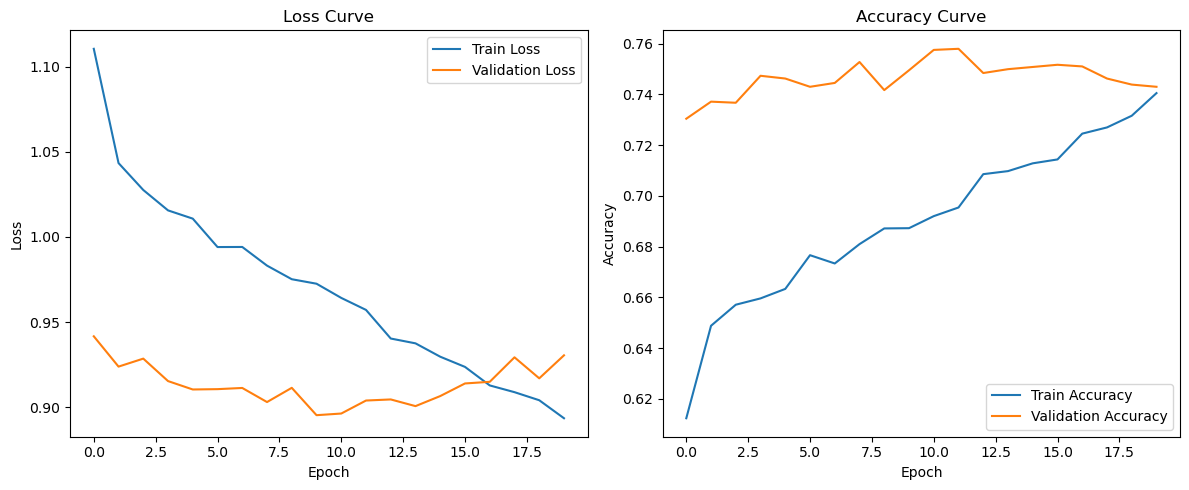

In [19]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

## More advanced finetung

### 🚀 **Key Techniques Used**

1. **Hyperparameter Optimization (Optuna)**  
   - Automated the search for optimal hyperparameters like hidden layer dimension, learning rate, weight decay, dropout, and batch size.  
   - Improves model performance without manual trial-and-error.

2. **Advanced Data Augmentation**  
   - **CutMix:** Enhances generalization by mixing images and labels, making the model robust to occlusions and mixed features.  
   - **Noise Injection:** Simulates diffusion process noise to train the classifier on noisy images, aligning with the guidance objective.

3. **Mixed Precision Training (AMP)**  
   - Reduces memory usage and speeds up training while maintaining accuracy through 16-bit floating point computations.  

4. **Stochastic Weight Averaging (SWA)**  
   - Averages weights over training epochs, improving generalization and stability of the model.

5. **Learning Rate Scheduling (CosineAnnealingLR & SWALR)**  
   - Adjusts learning rate dynamically to escape local minima and improve convergence.

6. **Soft Early Stopping**  
   - Monitors validation accuracy and halts training when improvements stagnate, preventing overfitting.

7. **Model & Hyperparameter Saving**  
   - Saves the best model and hyperparameters for reproducibility and further fine-tuning.

### 🎯 **Why These Techniques?**  
These methods collectively improve model robustness, reduce overfitting, and ensure the classifier can effectively guide the diffusion model—even in the presence of noise. The result is a high-performing model that aligns with the project’s goal of generating synthetic images under various camera settings.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import optuna
import os
import numpy as np
from tqdm import tqdm
from src.data import LensTypeDataset
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from torch.cuda.amp import GradScaler, autocast
import pandas as pd
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

/users/eleves-a/2024/elio.samaha/.conda/envs/env-lab6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------------------
# CONFIGURATION & SETUP
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

SAVE_DIR = "./checkpoints"
OUTPUT_DIR = "./output"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# ----------------------------
# ADVANCED DATA AUGMENTATION
# ----------------------------
def cutmix(images, labels, alpha=1.0):
    """Apply CutMix augmentation."""
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(images.size(0)).to(device)
    target_a, target_b = labels, labels[rand_index]

    _, _, H, W = images.size()
    cx, cy = np.random.randint(W), np.random.randint(H)
    cut_w, cut_h = int(W * np.sqrt(1 - lam)), int(H * np.sqrt(1 - lam))
    x1, x2 = np.clip(cx - cut_w // 2, 0, W), np.clip(cx + cut_w // 2, 0, W)
    y1, y2 = np.clip(cy - cut_h // 2, 0, H), np.clip(cy + cut_h // 2, 0, H)

    images[:, :, y1:y2, x1:x2] = images[rand_index, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    return images, target_a, target_b, lam

In [4]:
# ----------------------------
# DATA LOADERS
# ----------------------------
def get_loaders(batch_size, noise_probability=0.3, max_noise_std=0.4):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])

    transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])

    train_dataset = LensTypeDataset("./data", split="train", transform=transform_train,
                                     noisy_percentage=noise_probability, noise_stds=[max_noise_std])
    val_dataset = LensTypeDataset("./data", split="val", transform=transform_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

In [5]:
# ----------------------------
# MODEL DEFINITION
# ----------------------------
def build_model(hidden_units, dropout_rate):
    model = models.efficientnet_b3(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    in_feats = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_feats, hidden_units),
        nn.SiLU(inplace=True),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_units, 5)
    )
    return model.to(device)

In [6]:
# ----------------------------
# TRAINING AND VALIDATION LOOPS
# ----------------------------
def train_one_epoch(model, train_loader, optimizer, criterion, scaler):
    model.train()
    total_loss, correct = 0, 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        if np.random.rand() < 0.5:
            images, target_a, target_b, lam = cutmix(images, labels)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            if 'cutmix' in locals():
                loss = lam * criterion(outputs, target_a) + (1 - lam) * criterion(outputs, target_b)
            else:
                loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

def validate(model, val_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(val_loader.dataset), correct / len(val_loader.dataset)

In [ ]:
# ----------------------------
# OPTUNA TUNING
# ----------------------------
def objective(trial):
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
    hidden_units = trial.suggest_categorical("hidden_units", [256, 512, 1024])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_loader, val_loader = get_loaders(batch_size=batch_size)
    model = build_model(hidden_units, dropout_rate)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    scaler = GradScaler()

    best_val_acc = 0
    for epoch in range(10):
        train_one_epoch(model, train_loader, optimizer, criterion, scaler)
        _, val_acc = validate(model, val_loader, criterion)
        scheduler.step()
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

In [ ]:
# Save best hyperparameters
best_params = study.best_params
torch.save(best_params, os.path.join(SAVE_DIR, "best_hyperparams.pt"))
print("Best hyperparameters saved.")

Best hyperparameters saved.


In [ ]:
# ----------------------------
# FINAL TRAINING WITH METRIC TRACKING
# ----------------------------
def final_training(best_params, epochs=100, patience=10):
    train_loader, val_loader = get_loaders(batch_size=best_params['batch_size'])
    model = build_model(best_params['hidden_units'], best_params['dropout_rate'])
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = GradScaler()

    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, swa_lr=best_params['lr'] / 2)

    best_val_acc = 0
    patience_counter = 0

    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, "best_model.pth"))
            print(f"Best model saved with accuracy {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping.")
                break

        swa_model.update_parameters(model)
        swa_scheduler.step()

    # Update Batch Norm Statistics using SWA Model
    update_bn(train_loader, swa_model.to(device), device=device)  
    torch.save(swa_model.state_dict(), os.path.join(SAVE_DIR, "swa_model.pth"))
    print("✅ SWA Model saved.")

    # Save metrics to CSV
    metrics_df = pd.DataFrame({
        "epoch": list(range(1, len(train_losses) + 1)),
        "train_loss": train_losses,
        "train_accuracy": train_accuracies,
        "val_loss": val_losses,
        "val_accuracy": val_accuracies
    })
    metrics_df.to_csv(os.path.join(OUTPUT_DIR, "training_metrics.csv"), index=False)
    print("✅ Training metrics saved to 'output/training_metrics.csv'")

In [12]:
# Run final training with saved best parameters
best_params = torch.load(os.path.join(SAVE_DIR, "best_hyperparams.pt"))
final_training(best_params, epochs=100, patience=10)

/tmp/ipykernel_3685659/3604785639.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_params = torch.load(os.path.join(SAVE_DIR, "best_hyperparams.pt"))
/users/eleves-a


Epoch 1/100


Training:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_3685659/511986742.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating: 100%|██████████| 37/37 [00:27<00:00,  1.34it/s]


Best model saved with accuracy 0.6581

Epoch 2/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.44it/s]


Best model saved with accuracy 0.6649

Epoch 3/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]


Patience counter: 1/10

Epoch 4/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.42it/s]


Patience counter: 2/10

Epoch 5/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


Best model saved with accuracy 0.6672

Epoch 6/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]


Best model saved with accuracy 0.6679

Epoch 7/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


Best model saved with accuracy 0.6766

Epoch 8/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.44it/s]


Patience counter: 1/10

Epoch 9/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


Patience counter: 2/10

Epoch 10/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]


Best model saved with accuracy 0.6772

Epoch 11/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


Best model saved with accuracy 0.6861

Epoch 12/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


Patience counter: 1/10

Epoch 13/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


Patience counter: 2/10

Epoch 14/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.42it/s]


Patience counter: 3/10

Epoch 15/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]


Patience counter: 4/10

Epoch 16/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]


Patience counter: 5/10

Epoch 17/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]


Best model saved with accuracy 0.6894

Epoch 18/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.42it/s]


Patience counter: 1/10

Epoch 19/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]


Patience counter: 2/10

Epoch 20/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]


Patience counter: 3/10

Epoch 21/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]


Patience counter: 4/10

Epoch 22/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]


Patience counter: 5/10

Epoch 23/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]


Patience counter: 6/10

Epoch 24/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.41it/s]


Patience counter: 7/10

Epoch 25/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.43it/s]


Patience counter: 8/10

Epoch 26/100


Validating: 100%|██████████| 37/37 [00:26<00:00,  1.40it/s]


Patience counter: 9/10

Epoch 27/100


Validating: 100%|██████████| 37/37 [00:25<00:00,  1.44it/s]

Patience counter: 10/10
Early stopping.


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [13]:
# ----------------------------
# PLOTTING METRICS
# ----------------------------
metrics_df = pd.read_csv(os.path.join(OUTPUT_DIR, "training_metrics.csv"))

plt.figure(figsize=(12, 5))
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(metrics_df['epoch'], metrics_df['train_accuracy'], label='Train Accuracy')
plt.plot(metrics_df['epoch'], metrics_df['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './output/training_metrics.csv'

# Testing